## Neural Machine Translation using Google's Encoder Decoder Architecture

### Importing all the dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tarfile
import os
import random
import matplotlib.pyplot as plt

### Getting one with the dataset

In [2]:
# Extracting all the files from the tar file
if not os.path.exists('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki'):
    tar_ref = tarfile.TarFile('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki-titles.tar')
    tar_ref.extractall()
    print('Files extracted')

In [3]:
# Extracting data from the file
with open('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki/hi-en/wiki-titles.hi-en', 'r') as f:
    lines = f.readlines()

len(lines)

32863

In [4]:
# Separating english from hindi
hin_sentences = [line.split('|||')[0] for line in lines]
eng_sentences = [line.split('|||')[1][:-1] for line in lines]
len(hin_sentences), len(eng_sentences)

(32863, 32863)

### Visualising the dataset we have

In [5]:
random_idx = random.choices(range(len(hin_sentences)), k= 5)
for idx in random_idx:
    print(f"English sentence: {eng_sentences[idx]}")
    print(f"Hindi sentce: {hin_sentences[idx]}")
    print('--------------------\n')

English sentence:  1226
Hindi sentce: १२२६ 
--------------------

English sentence:  Mechanised Infantry Regiment
Hindi sentce: मेकनाईजड इन्फ़ेन्ट्री रेजीमेंट 
--------------------

English sentence:  Infosys
Hindi sentce: इंफोसिस 
--------------------

English sentence:  1986
Hindi sentce: १९८६ 
--------------------

English sentence:  Sanskrit grammar
Hindi sentce: संस्कृत व्याकरण 
--------------------


In [6]:
# Lets look at the distibution of number of words per sentence
eng_words_sentences = [len(sentence.split()) for sentence in eng_sentences]
hin_word_sentences = [len(sentence.split()) for sentence in hin_sentences]

len(eng_words_sentences), len(hin_word_sentences)

(32863, 32863)

In [7]:
# Create vocabulary set for both the language
eng_vocab = set()

for line in eng_sentences:
    for word in line.split():
        eng_vocab.add(word)

eng_vocab.add('<SOS>')
eng_vocab.add('<EOS>')
len(eng_vocab)

28853

In [8]:
english_dictionary = pd.DataFrame(eng_vocab)

In [9]:
# Cross verifying the values
english_dictionary.nunique()

0    28853
dtype: int64

In [10]:
# Storing vocab value of hindi same as english
hin_vocab = set()

for line in hin_sentences:
    for word in line.split():
        hin_vocab.add(word)

len(hin_vocab)

29073

In [11]:
# Cross verifying
hindi_dictionary = pd.DataFrame(hin_vocab)
hindi_dictionary.nunique()

0    29073
dtype: int64

(array([2.4237e+04, 5.2690e+03, 2.4600e+03, 3.4200e+02, 2.4100e+02,
        2.9000e+02, 1.1000e+01, 1.1000e+01, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

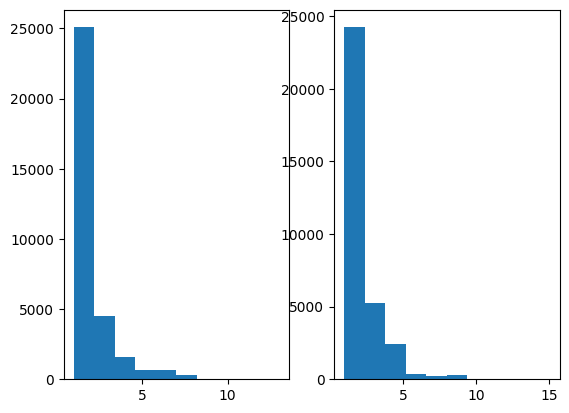

In [12]:
# Plotting number of words distribution
plt.subplot(1, 2, 1)
plt.hist(eng_words_sentences)

plt.subplot(1, 2, 2)
plt.hist(hin_word_sentences)

In [13]:
# Let's cover the maximum number of data
max_len_eng = np.percentile(eng_words_sentences, 0.99)
max_len_hin = np.percentile(hin_word_sentences, 0.99)
max_len_eng, max_len_hin

(1.0, 1.0)

## Preprocess the data

In [14]:
def preprocess_sentence(sentences: list):
    return ['<SOS> ' + sentence.strip() + ' <EOS>' for sentence in sentences]

In [15]:
eng_sentences_preprocessed = preprocess_sentence(eng_sentences)
hin_sentences_preprocessed = preprocess_sentence(hin_sentences)

In [16]:
random_idx = random.randint(0, len(eng_sentences_preprocessed) - 1)
print(eng_sentences_preprocessed[random_idx])
print(hin_sentences_preprocessed[random_idx])

<SOS> Hemu Kalani <EOS>
<SOS> हेमू कालाणी <EOS>


### Create Encoder class

In [201]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, vocab, embedding_size, units, encoding_layers, **kwargs):
        # initialisation of the variables
        super().__init__(**kwargs)
        self.vocab = vocab
        self.units = units
        self.encoding_layers = encoding_layers
        self.embedding_size = embedding_size

        #initialisation of the layers required
        # self.input_layer = layers.Input(shape= (None, ), dtype= tf.int32)
        self.embedding = layers.Embedding(input_dim= self.vocab,
                                          output_dim= self.embedding_size,name= 'encoder_embedding_layer')
        self.lstm_init_units = 2 * (self.embedding_size + self.units)
        self.lstm_layers_recurrent = []
        self.lstm_layers_recurrent.append(layers.LSTM(self.lstm_init_units, return_sequences=True, name= 'lst_layers_recurrent_0'))
        self.lstm_units = self.lstm_init_units
        for _ in range(self.encoding_layers - 3):
            self.lstm_units += (self.embedding_size + self.units)
            self.lstm_layers_recurrent.append(layers.LSTM(self.lstm_units, return_sequences=True, name=f'lstm_layers_recurrent_{_ + 1}'))
        self.lstm_layer_non_recurrent = layers.LSTM(self.units, return_sequences=False, name= 'lstm_layer_non_recurrent')
        self.bilst_layer = layers.Bidirectional(layers.LSTM(self.units // 2, return_sequences=True), name= 'bilst_layer')
        self.concatenate_layer = layers.Concatenate(name= 'concatenate_layer')
        self.dropout_layer = layers.Dropout(0.5, name= 'dropout_layer')
        

    def call(self, inputs):
        x = self.embedding(inputs)
        bilstm_output = self.bilst_layer(x)
        x = self.dropout_layer(bilstm_output)
        x = self.concatenate_layer([bilstm_output, x])
        for i in range(self.encoding_layers - 2):
            lstm_layer_output = self.lstm_layers_recurrent[i](x)
            lstm_layer_output = self.dropout_layer(lstm_layer_output)
            x = self.concatenate_layer([lstm_layer_output, x])
        x = self.lstm_layer_non_recurrent(x)
        x = self.dropout_layer(x)
        x = tf.keras.layers.Dense(15, activation= 'softmax')(x)
        
        return x


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(eng_sentences_preprocessed, hin_sentences_preprocessed, test_size= 0.2,
                                                    random_state= 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(26290, 6573, 26290, 6573)

In [26]:
# Creating a text vectorization for the source language
eng_vectorizer = layers.TextVectorization(max_tokens= len(eng_vocab),
                                          pad_to_max_tokens= True)

eng_vectorizer.adapt(X_train)



In [27]:
# A sample action of our text vectorization
random_text = random.choice(X_train)
print(f"Original text: {random_text}")
print(f"Vectorized text: {eng_vectorizer(random_text)}")

Original text: <SOS> Mobile number portability <EOS>
Vectorized text: [    2   503    64 10603     3]


In [202]:
# Creating an instance of our encoder layer
encoder_layer = Encoder(vocab= len(eng_vocab),
                        embedding_size= 128,
                        units= 512,
                        encoding_layers= 8,
                        name= 'encoder_layer', trainable= True)


encoder_layer.get_config()

{'name': 'encoder_layer',
 'vocab': 28853,
 'embedding_size': 128,
 'units': 512,
 'encoding_layers': 8,
 'trainable': True,
 'dtype': 'float32'}

In [104]:
print(len(X_train[0].split()))
print(eng_vectorizer(X_train[0]).shape)

4
(4,)


In [203]:
with tf.device('GPU:0'):
    encoder_layer(eng_vectorizer(X_train[:1])) 

In [197]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, eng_vectorizer(X_train))).batch(128).prefetch(tf.data.AUTOTUNE)
valid_data = tf.data.Dataset.from_tensor_slices((X_test, eng_vectorizer(X_test))).batch(128).prefetch(tf.data.AUTOTUNE)

In [205]:
model = tf.keras.Sequential([
    eng_vectorizer,
    encoder_layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.build()

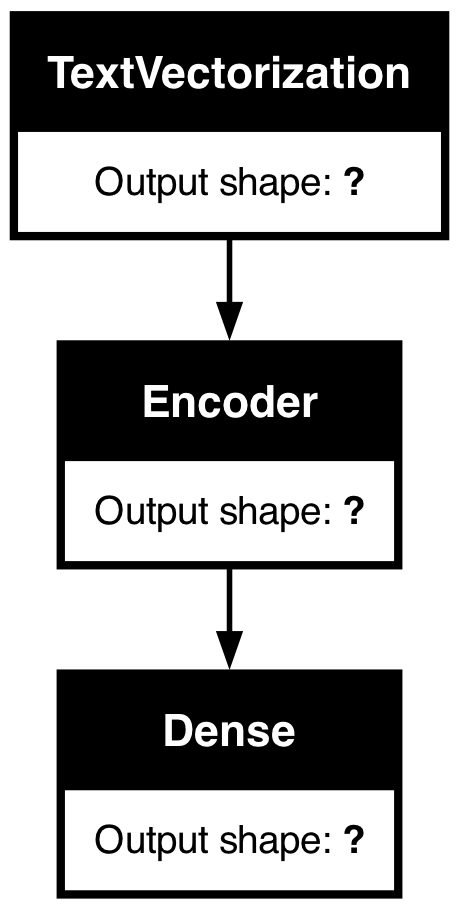

In [185]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [206]:
# Fit the model
with tf.device('GPU:0'):
    history = model.fit(train_data,
                      epochs= 5,
                        verbose= 1,
                      validation_data= valid_data,
                      callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath= 'GNMT_exp.weights.h5', monitor='val_loss', save_best_only= True, save_weights_only=True),
                         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights= True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience= 2, factor=0.1)])

Epoch 1/5


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 15), output.shape=(None, 15)